In [118]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import h5py as h5
import hdf5plugin
from matplotlib.colors import LogNorm
from lmfit import Model
from lmfit.models import GaussianModel, ConstantModel

from scipy.integrate import trapz
from scipy.optimize import curve_fit
from scipy import ndimage

from importlib import reload

# sys.path.append('/reg/neh/home/espov/python/scikit-beam')
import skbeam.core.correlation as corr

import lsco_ana as ana
reload(ana)

<module 'lsco_ana' from 'C:\\Users\\espov\\Documents\\Science_projects\\LSCO\\DESY\\lsco_ana.py'>

In [2]:
plt.style.use('dark_background')
#matplotlib.rcParams.keys()
plt.rcParams['figure.figsize'] = (10, 6)
plt.rc('font', size=12)
length = 8
width = 1.5
plt.rcParams['xtick.major.size'] = length
plt.rcParams['ytick.major.size'] = length
plt.rcParams['xtick.major.width'] = width
plt.rcParams['ytick.major.width'] = width

Image number of interest: 50
Center of Mass of the image : 301, 300


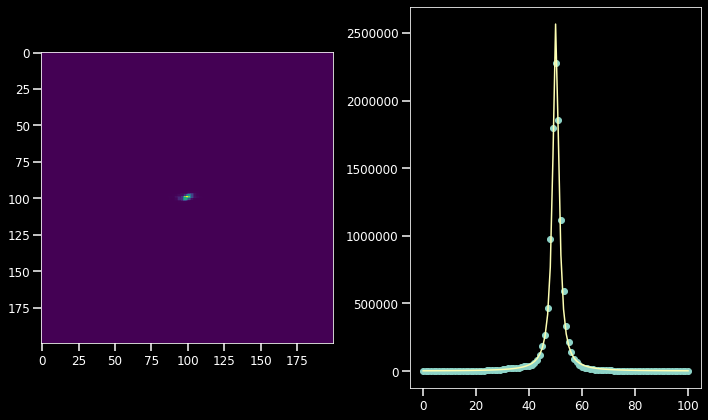

(1800, 600, 600)


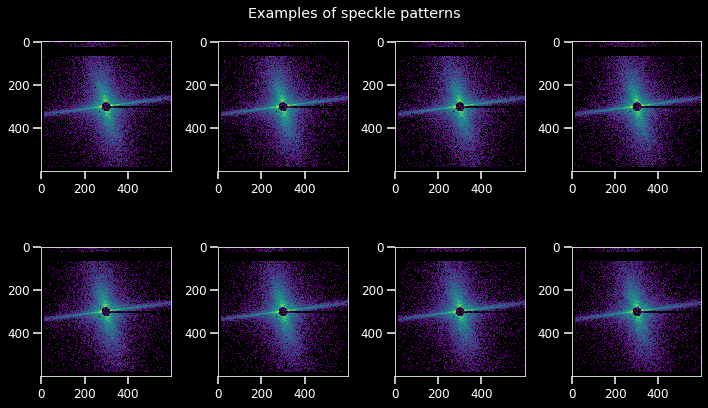

In [3]:
data_dir = Path(r'C:\Users\espov\Desktop\DESY')
r_th = 24
r_time = 25
drow1, drow2, dcol1, dcol2 = 300,300,300,300  # region of interest size

# Analyze th scan: find peak center
feiger, fmaster, fbatchinfo = ana.get_file_name(r_th, data_dir)
feiger = h5.File(feiger, 'r')
fmaster = h5.File(fmaster, 'r')
eiger = np.asarray(feiger['entry']['data']['data'])
qoi,com = ana.centering_ls(eiger, drow1, drow2, dcol1, dcol2)

# Analyze time series
feiger, fmaster, fbatchinfo = ana.get_file_name(r_time, data_dir)
feiger = h5.File(feiger, 'r')
fmaster = h5.File(fmaster, 'r')
eiger = np.asarray(feiger['entry']['data']['data'][:,qoi[0]:qoi[1], qoi[2]:qoi[3]])
print(eiger.shape)
eiger[eiger>1e7] = 0
fig, axs = plt.subplots(nrows=2, ncols=4)
fig.suptitle('Examples of speckle patterns')
for ii, ax in enumerate(axs.ravel()):
    ax.imshow(eiger[100*ii], norm=LogNorm())
plt.tight_layout()
plt.show()

In [4]:
tmin = ana.info_reader_ls(fbatchinfo)

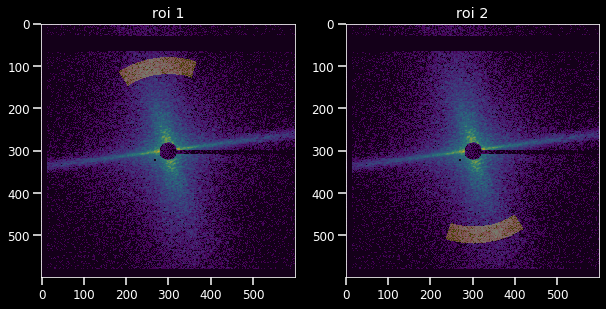

In [5]:
reload(ana)
rad, phi = ana.polarCoord(eiger[0].shape, com)
r0, dr, phi0, dphi, tilt = 200., 20., 90., 25, 7.5
roi1 = ana.roi_lsco(eiger[0], com, r0, dr, phi0, dphi, tilt)
r0, dr, phi0, dphi, tilt = 200., 20., -90., 25, 7.5
roi2 = ana.roi_lsco(eiger[0], com, r0, dr, phi0, dphi, tilt)

fig, ax = plt.subplots(ncols=2)
ax[0].imshow(eiger[0], norm=LogNorm())
ax[0].imshow(roi1, alpha=0.3)
ax[0].set_title('roi 1')
ax[1].imshow(eiger[0], norm=LogNorm())
ax[1].imshow(roi2, alpha=0.3)
ax[1].set_title('roi 2')
plt.show()

# Two-time correlation function

In [6]:
num_levels = 1
num_bufs = eiger.shape[0]
num_frames = eiger.shape[0]

twoTime_roi1 = corr.two_time_corr(roi1, eiger, num_frames, num_bufs, num_levels=1)

In [7]:
twoTime_roi2 = corr.two_time_corr(roi2, eiger, num_frames, num_bufs, num_levels=1)

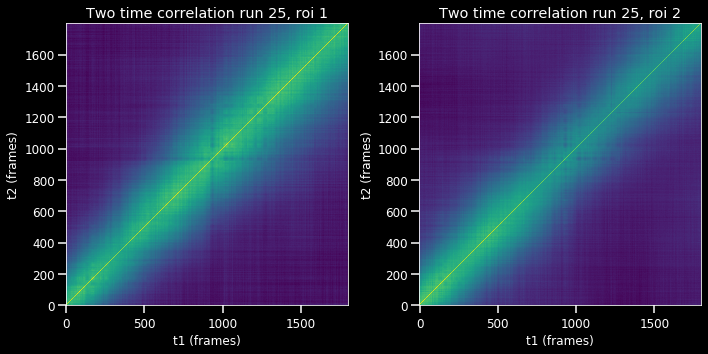

In [8]:
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(twoTime_roi1.g2[0], origin="lower")
ax[0].set_xlabel("t1 (frames)")
ax[0].set_ylabel("t2 (frames)")
ax[0].set_title("Two time correlation run 25, roi 1")

ax[1].imshow(twoTime_roi2.g2[0], origin="lower")
ax[1].set_xlabel("t1 (frames)")
ax[1].set_ylabel("t2 (frames)")
ax[1].set_title("Two time correlation run 25, roi 2")
plt.tight_layout()
plt.show()

## One-time correlation functions

In [127]:
results = []

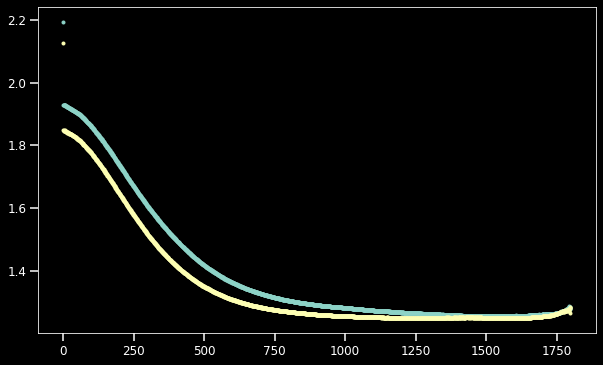

In [21]:
fig, ax = plt.subplots()

two_time_corr = twoTime_roi1.g2
g2 = corr.one_time_from_two_time(two_time_corr).squeeze()
lag_steps = np.arange(g2.shape[0])
ax.plot(lag_steps, g2, 'o', markersize=3)
results.append([g2, lag_steps])
two_time_corr = twoTime_roi2.g2
g2 = corr.one_time_from_two_time(two_time_corr).squeeze()
lag_steps = np.arange(g2.shape[0])
ax.plot(lag_steps, g2, 'o', markersize=3)
results.append([g2, lag_steps])

plt.show()

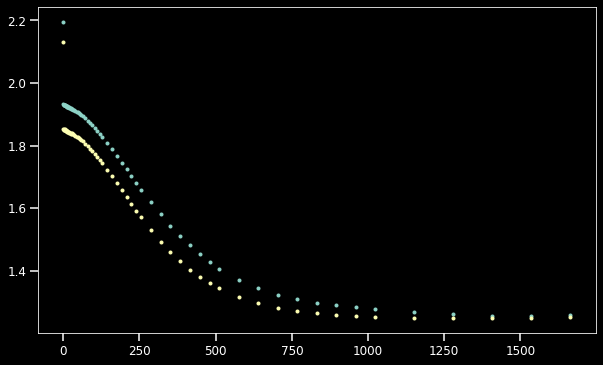

In [22]:
num_levels = 10
num_bufs = 16

fig, ax = plt.subplots()
g2, lag_steps = corr.multi_tau_auto_corr(num_levels, num_bufs, roi1, (im for im in eiger))
ax.plot(lag_steps, g2, 'o', markersize=3)
results.append([g2, lag_steps])
g2, lag_steps = corr.multi_tau_auto_corr(num_levels, num_bufs, roi2, (im for im in eiger))
ax.plot(lag_steps, g2, 'o', markersize=3)
results.append([g2, lag_steps])

plt.show()

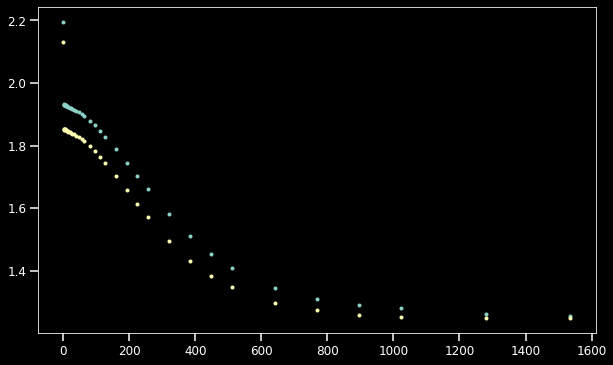

In [128]:
num_levels = 10
num_bufs = 8

fig, ax = plt.subplots()
g2, lag_steps = corr.multi_tau_auto_corr(num_levels, num_bufs, roi1, (im for im in eiger))
ax.plot(lag_steps, g2, 'o', markersize=3)
results.append([g2, lag_steps])
g2, lag_steps = corr.multi_tau_auto_corr(num_levels, num_bufs, roi2, (im for im in eiger))
ax.plot(lag_steps, g2, 'o', markersize=3)
results.append([g2, lag_steps])

plt.show()

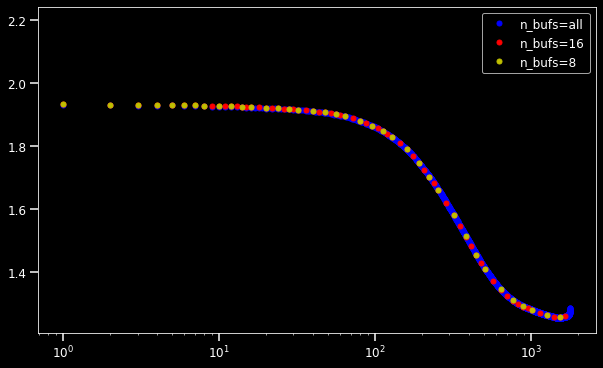

In [24]:
fig, ax = plt.subplots()
colors = ['b','r','y']
labels = ['n_bufs=all', 'n_bufs=16', 'n_bufs=8']
for res, col, label in zip(results[::2], colors, labels):
    g2 = res[0]
    lag = res[1]
    ax.plot(lag, g2, 'o', color=col, markersize=5, label=label)
ax.legend()
ax.set_xscale('log')
plt.show()

# Calculate correlation in Fourier space: spatial and time correlation

Compare Yanwen's code and mine

### (i) Correlation of the roi with the large bounding box

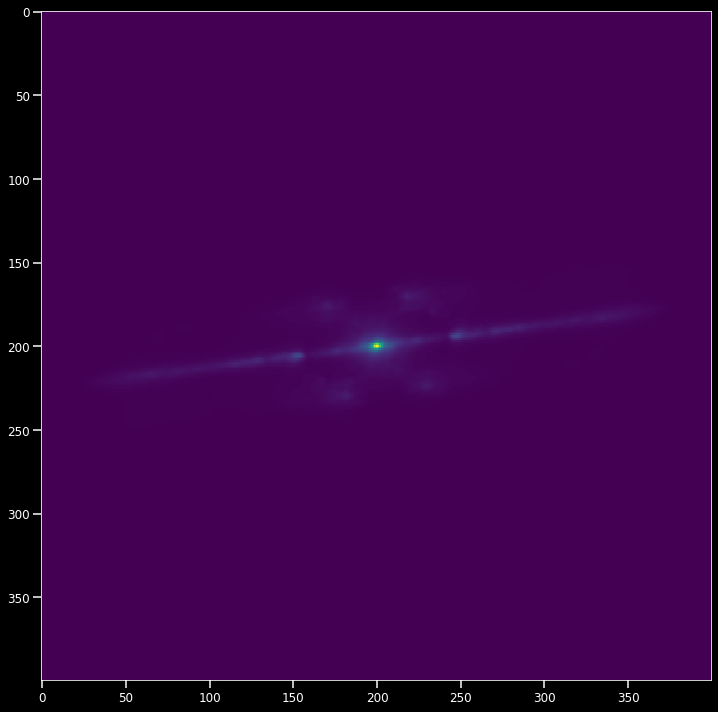

In [241]:
reload(ana)
imgs = eiger[:10]
mask = roi1
nframe = imgs.shape[0]
A = np.zeros([nframe,nframe])

fmask = np.fft.rfft2(mask)
fmask_star = np.conjugate(fmask)
fimgs = np.fft.rfft2(imgs)
fimgs_star = np.conjugate(fimgs)

A = ana._spatial_correlation_fourier(fimgs[0], fimgs_star[0], fmask, fmask_star)
fig, ax = plt.subplots(figsize=(12,14))
ax.imshow(A[100:500,100:500])
# ax.imshow(A)
plt.show()

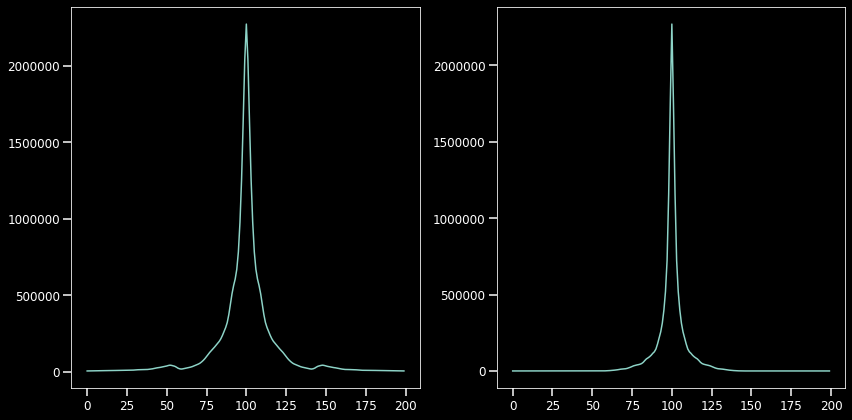

In [242]:
xx = A.shape[0]//2
yy = A.shape[1]//2
fig, ax = plt.subplots(ncols=2, figsize=(12,6))
ax[0].plot(A[xx,200:400])
ax[1].plot(A[200:400,yy])
plt.tight_layout()
plt.show()

There seem to be a problem with the normalization.

In [243]:
fim1, fim2_star, fmask, fmask_star = fimgs[0], fimgs_star[0], fmask, fmask_star
A_denom = np.fft.irfft2(fim1*fmask_star) * np.fft.irfft2(fim2_star*fmask)
A_denom = np.fft.fftshift(A_denom)

A_num1 = np.fft.irfft2(fim1*fim2_star)
A_num2 = np.fft.irfft2(fmask*fmask_star)
A_num = A_num1 * A_num2
A_num = np.fft.fftshift(A_num)

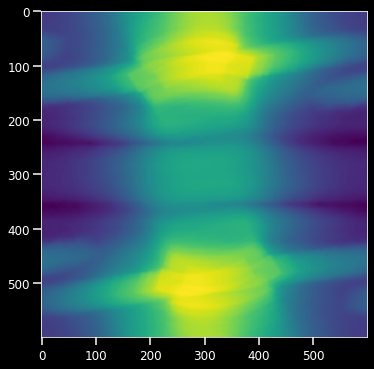

In [244]:
plt.imshow(A_denom, norm=LogNorm())

## (ii) Autocorrelation on the bounding box of the ROI

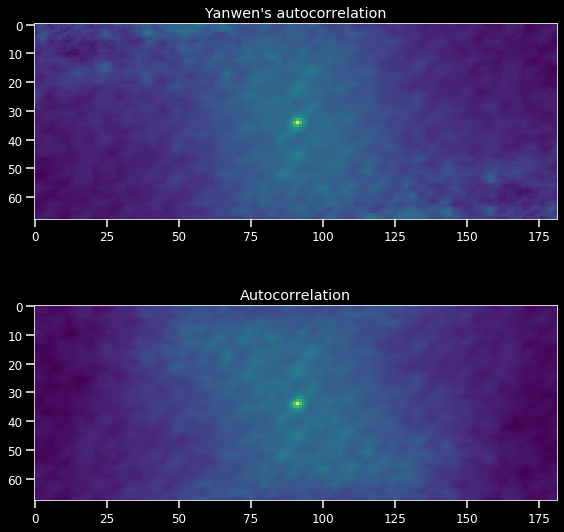

In [245]:
import autocor_yanwen as auto
img = imgs[3]
i0, autocorr = auto.calcAutoCorr(img, mask=mask)

fig, ax = plt.subplots(nrows=2, figsize=(8,8))
ax[0].imshow(autocorr)
ax[0].set_title("Yanwen's autocorrelation")


img = imgs[3]
A = ana.spatial_correlation_fourier(img, mask=mask)
ax[1].imshow(A)
ax[1].set_title("Autocorrelation")
plt.tight_layout()
plt.show()

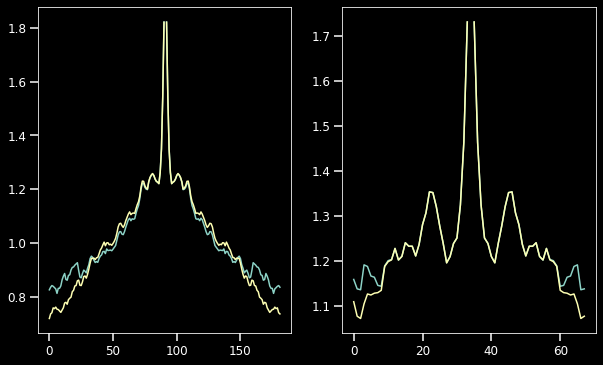

In [246]:
xx = autocorr.shape[0]//2
yy = autocorr.shape[1]//2
autocorr2 = ana.remove_central_corr(autocorr)
A2 = ana.remove_central_corr(A)
fig, ax = plt.subplots(ncols=2)
ax[0].plot(autocorr2[xx,:])
ax[0].plot(A2[xx,:])

ax[1].plot(autocorr2[:,yy])
ax[1].plot(A2[:,yy])
plt.show()

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 333.68it/s]


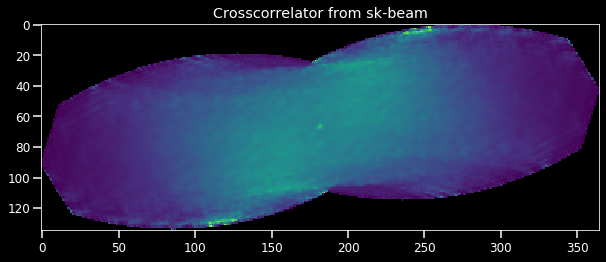

In [247]:
ccorr = corr.CrossCorrelator(mask.shape, mask=mask)
cc1 = ccorr(img)
plt.imshow(cc1)
plt.title('Crosscorrelator from sk-beam')
plt.show()

## Fit speckle size

[[Model]]
    (Model(gaussian) + Model(constant))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 31
    # data points      = 15
    # variables        = 4
    chi-square         = 0.00382870
    reduced chi-square = 3.4806e-04
    Akaike info crit   = -116.099211
    Bayesian info crit = -113.267010
[[Variables]]
    amplitude:  2.36615836 +/- 0.07594636 (3.21%) (init = 3)
    center:     7.99999986 +/- 0.03906560 (0.49%) (init = 8.5)
    sigma:      1.51283188 +/- 0.05385441 (3.56%) (init = 2)
    c:          1.22206829 +/- 0.00669684 (0.55%) (init = 1)
    fwhm:       3.56244677 +/- 0.12681744 (3.56%) == '2.3548200*sigma'
    height:     0.62396931 +/- 0.02114149 (3.39%) == '0.3989423*amplitude/max(2.220446049250313e-16, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, c)     = -0.668
    C(amplitude, sigma) =  0.503
    C(sigma, c)         = -0.501


[[Model]]
    (Model(gaussian) + Model(constant))
[[Fit Statistics]]
    

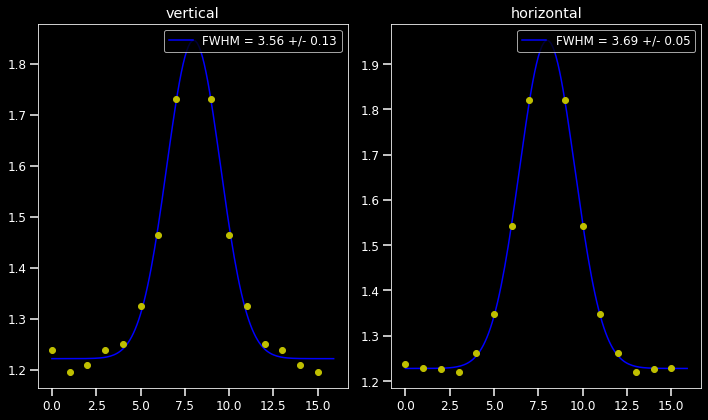

In [248]:
n = 8 # range for the fit
horiz = A2[xx,:]
vert = A2[:,yy]
data = [vert, horiz]
titles = ['vertical', 'horizontal']

fig, ax = plt.subplots(ncols=2)
for ii, dat in enumerate(data):
    gmodel = GaussianModel(nan_policy='omit')+ConstantModel(nan_policy='omit')
    params = gmodel.make_params()
    params['amplitude'].value = 3
    params['sigma'].value = 2
    params['center'].value = (2*n+1)/2
    params['c'].value = 1
    
    center = np.where(np.isnan(dat))[0][0]
    dat = dat[center-n:center+n]
    x = np.arange(dat.shape[0])
    res = gmodel.fit(dat, params, x=x)
    
    xfit = np.arange(0,2*n,0.1)
    ax[ii].plot(xfit, res.eval(x=xfit), color='b', 
                label='FWHM = {:.2f} +/- {:.2f}'.format(res.params['fwhm'].value, res.params['fwhm'].stderr))
    ax[ii].plot(dat, 'o', color='y')
    ax[ii].legend(loc='upper right')
    ax[ii].set_title(titles[ii])
    print(res.fit_report())
    print('\n')
    
plt.tight_layout()
plt.show()